# Convolution comparison in Julia

### Load packages/functions

In [1]:
]activate .

  Activating project at `E:\_Code\dceConvGH\Julia`


This should install the required dependencies (if they are missing)

In [2]:
]instantiate

In [3]:
# Load requires packages
using DSP # for fftconv
using LsqFit # for nonlinear fitting
using MAT # for i/o
using NumericalIntegration # for integralconv
using NamedTupleTools # for convenience
using Plots # for seeing
using Statistics # for statting
using TimerOutputs # for evaluating computation time

# Config for plots
figopts = (; framestyle = :grid, gridalpha=0.5, gridstyle=:dot, linewidth = 2.5, markersize=10, markerstrokewidth = 0,
            tickfontsize = 11, size =(1200, 400), legend = :none, foreground_color_legend = nothing, margin=10Plots.mm)
nothing

The code here is not (that) important.
It's mostly used for fitting the Tofts model, but it's a bit messy. 
It'll be cleaned up. Eventually. Maybe.

In [4]:
percenterror(a,b) = 100 * (a-b) / b

downsample(x::Vector, rate, phase=1) = Downsample(x, Int(rate), phase)
function downsample(x::Vector, rate::Int, phase::Int=1)
    return x[phase:rate:end]
end

function downsample(x::Array, rate::Int, phase::Int=1; dim::Int=1)
    @assert (dim <= ndims(x))  "dim can't be larged than dimensions of data"
    if ndims(x)==3
        if dim==1
            return x[phase:rate:end, :, :]
        elseif dim==2
            return x[:, phase:rate:end, :]
        elseif dim==3
            return x[:, :, phase:rate:end]
        else
            ErrorException()
        end
    elseif ndims(x)==2
        if dim==1
            return x[phase:rate:end, :]
        elseif dim==2
            return x[:, phase:rate:end]
        else
            ErrorException()
        end
    else
        ErrorException("Unsupported input")
    end
    return x
end

function get_qiba_ground_truth()
  kt_values = [0.01, 0.02, 0.05, 0.1, 0.2, 0.35]
  ve_values = [0.01, 0.05, 0.1, 0.2, 0.5]
  kt = repeat(kt_values; inner = (1, 5))
  ve = repeat(ve_values'; inner = (6, 1))
  kep = kt ./ ve
  return (; kt, ve, kep = kt ./ ve)
end

function fit_tofts_lls(;
    t::AbstractVector,
    ca::AbstractVector,
    ct::AbstractArray,
    mask = true,
)
    (t, ct, mask, num_timepoints, volume_size) = resolve_fitting_inputs(; t, ca, ct, mask)
    kt, kep = (fill(NaN, volume_size...) for _ = 1:2)

    M = zeros(num_timepoints, 2)
    M[:, 1] = cumul_integrate(t, ca, TrapezoidalFast())
    for idx in eachindex(IndexCartesian(), mask)
        if mask[idx] == false
            continue
        end
        M[:, 2] = -cumul_integrate(t, ct[idx, :], TrapezoidalFast())
        (kt[idx], kep[idx]) = M \ ct[idx, :]
    end
    est = compute_ve_or_kep_if_it_is_missing((; kt, kep))
    return est
end

function fit_tofts_nls(
    conv::Function = expconv;
    t::AbstractVector,
    ca::AbstractVector,
    ct::AbstractArray,
    mask = true,
)
    (t, ct, mask, num_timepoints, volume_size) = resolve_fitting_inputs(; t, ca, ct, mask)
    kt, kep = (fill(NaN, volume_size...) for _ = 1:2)
    model(x, p) = _model_tofts(conv, x, p, ca)
    lls_est = fit_tofts_lls(; t, ca, ct, mask)
    init_kt, init_kep = select(lls_est, (:kt, :kep))
    for idx in eachindex(IndexCartesian(), mask)
        if mask[idx] == false
            continue
        end
        initialvalues = [init_kt[idx], init_kep[idx]]
        (kt[idx], kep[idx]) = curve_fit(model, t, ct[idx, :], initialvalues).param
    end
    est = compute_ve_or_kep_if_it_is_missing((; kt, kep))
    return est
end

function _model_tofts(
    conv::Function,
    t::AbstractVector,
    params::AbstractVector,
    ca::AbstractVector,
)
    kt, kep = params
    ct = kt * conv(ca, kep, t)
    return ct
end

function resolve_fitting_inputs(; t, ca, ct, mask)
    @assert length(t) == length(ca) == size(ct)[end]
    num_timepoints = length(t)
    if typeof(ct) <: AbstractVector
        @assert length(ct) == num_timepoints
        ct = reshape(ct, 1, num_timepoints)
    end
    volume_size = size(ct)[1:end-1]
    resolved_mask = resolve_mask_size(mask, volume_size)
    return (t, ct, resolved_mask, num_timepoints, volume_size)
end

function resolve_mask_size(mask, desired_size)
    if size(mask) == desired_size
        return mask .> 0
    elseif size(mask) == ()
        return repeat([mask .> 0], desired_size...)
    else
        error("Mask size: $(size(mask)) does not match input size $(desired_size)")
    end
end

function compute_ve_or_kep_if_it_is_missing(namedtuple::NamedTuple)
    if !haskey(namedtuple, :kep)
        return (namedtuple..., kep = namedtuple.kt ./ namedtuple.ve)
    elseif !haskey(namedtuple, :ve)
        return (namedtuple..., ve = namedtuple.kt ./ namedtuple.kep)
    else
        return namedtuple
    end
end

function compute_ve_or_kep_if_it_is_missing!(collection)
    for (key, values) in collection
        if !haskey(values, :kep)
            collection[key] = (values..., kep = values.kt ./ values.ve)
        end
        if !haskey(values, :ve)
            collection[key] = (values..., ve = values.kt ./ values.kep)
        end
    end
    return collection
end

compute_ve_or_kep_if_it_is_missing! (generic function with 1 method)

### Relevant code

These are the different convolution implementations

In [5]:
# These are the different convolution implementations

function fftconv(a, b, t)
    # Uses conv() from DSP.jl which uses fft (I think so based on its source code?)
    exp_term = @. exp(-t*b)
    return conv(a, exp_term)[1:length(t)] .* (t[2]-t[1])
end

# Adapted from David Smith's original implementation DCEMRI.jl
function intconv(ca,kep,t)
    Ct = zeros(length(t));
    for k in 1:length(Ct)
        tk = t[k]
        @simd for j = 1:k
            @inbounds y = exp(kep*(t[j] - tk)) * ca[j]
            @inbounds Ct[k] += ifelse((j == 1 || j == k) && k > 1, 0.5*y, y)
        end
    end
    dtp = (t[2] - t[1])
    @simd for k = 1:length(Ct)
        @inbounds Ct[k] *= dtp
    end
    return Ct
end

function expconv(A, B, t)
    # Returns f = A ConvolvedWith exp(-B t)
    # Based on Flouri et al. (2016) MRM 76(3), doi: 10.1002/mrm.25991
    @assert length(A) == length(t)
    f = zeros(length(t))
    for i = 2:length(t)
        x = B * (t[i] - t[i-1])
        dA = (A[i] - A[i-1]) / x
        E = exp(-x)
        E0 = 1 - E
        E1 = x - E0
        f[i] = E * f[i-1] + A[i-1] * E0 + dA * E1
    end
    return f ./ B
end


expconv (generic function with 1 method)

Get the ground truth and load the QIBA phantom data

In [6]:
truth = get_qiba_ground_truth()

mat = matread("../MATLAB/data/qiba.mat")
t = mat["t"] |> vec
ca = mat["ca"] |> vec
ct = mat["ct"]

# This will be used for plotting later
axesprops = (; 
    xticks = ([1,2,3,4,5], unique(truth.ve)),
    yticks = ([1,2,3,4,5,6], unique(truth.kt)),
    c = cgrad(:RdBu_9; rev = true)
    )
nothing

Fit Tofts model to QIBA phantom using the different convolution implementations

In [7]:
est = Dict()
est[:iterative] = fit_tofts_nls(expconv; ca, ct, t)
est[:fft] = fit_tofts_nls(fftconv; ca, ct, t)
est[:integral] = fit_tofts_nls(intconv; ca, ct, t)
est[:lls] = fit_tofts_lls(; ca, ct, t)
nothing

### Make error map plots

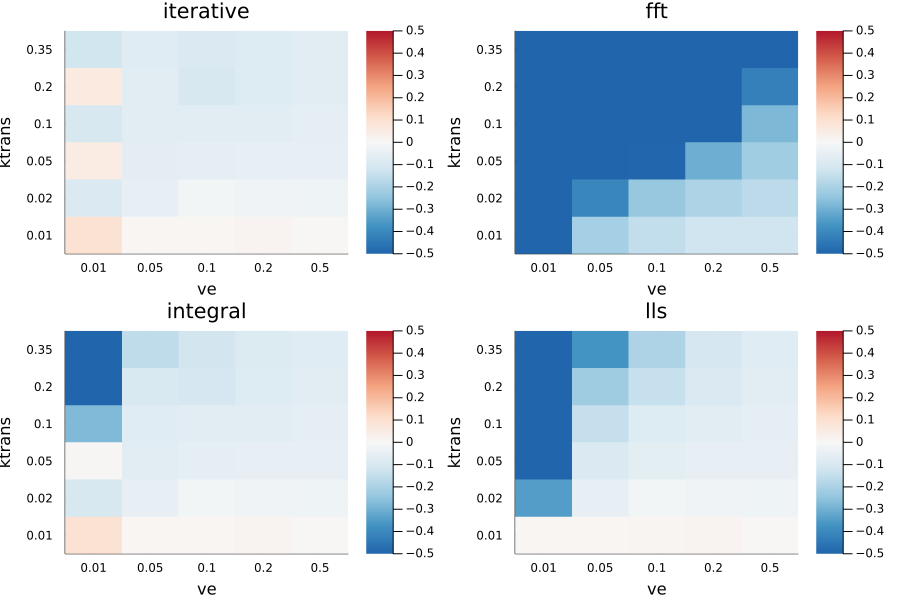

In [8]:
param = :kt
cmax = 0.5;
groundtruth = truth[param]
p1 = heatmap(percenterror.(est[:iterative][param], groundtruth); clim = (-cmax, cmax), title = "iterative", axesprops...)
p2 = heatmap(percenterror.(est[:fft][param], groundtruth); clim = (-cmax, cmax), title = "fft", axesprops...)
p3 = heatmap(percenterror.(est[:integral][param], groundtruth); clim = (-cmax, cmax), title = "integral", axesprops...)
p4 = heatmap(percenterror.(est[:lls][param], groundtruth); clim = (-cmax, cmax), title = "lls", axesprops...)
p_errkt = plot(p1, p2, p3, p4; layout = 4, size = (900, 600), xlabel="ve", ylabel = "ktrans")

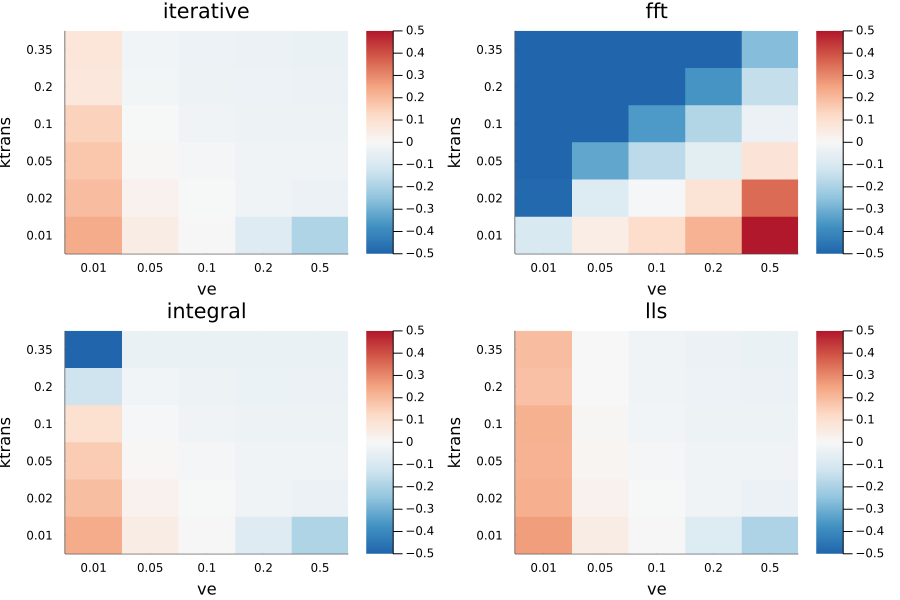

In [9]:
param = :ve
cmax = 0.5;
groundtruth = truth[param]
p1 = heatmap(percenterror.(est[:iterative][param], groundtruth); clim = (-cmax, cmax), title = "iterative", axesprops...)
p2 = heatmap(percenterror.(est[:fft][param], groundtruth); clim = (-cmax, cmax), title = "fft", axesprops...)
p3 = heatmap(percenterror.(est[:integral][param], groundtruth); clim = (-cmax, cmax), title = "integral", axesprops...)
p4 = heatmap(percenterror.(est[:lls][param], groundtruth); clim = (-cmax, cmax), title = "lls", axesprops...)
p_errkt = plot(p1, p2, p3, p4; layout = 4, size = (900, 600), xlabel="ve", ylabel = "ktrans")

# Benchmarks

In [10]:
using BenchmarkTools

In [11]:
@benchmark fit_tofts_nls(expconv; ca, ct, t)

BenchmarkTools.Trial: 149 samples with 1 evaluation.
 Range (min … max):  30.452 ms … 57.326 ms  ┊ GC (min … max): 10.02% … 17.82%
 Time  (median):     32.463 ms              ┊ GC (median):    10.24%
 Time  (mean ± σ):   33.726 ms ±  4.447 ms  ┊ GC (mean ± σ):  10.96% ±  3.04%

   ▁▇█▇▇▄▃▂                                                    
  █████████▅▅▅▅▁▁▁▁▅▁▁▁▅▁▁▁▁▅▁▅▅▁▁▅▁▁▇▅▁▅▁▁▁▁▅▅▁▁▁▁▁▁▁▁▁▁▁▁▁▅ ▅
  30.5 ms      Histogram: log(frequency) by time      55.9 ms <

 Memory estimate: 66.74 MiB, allocs estimate: 9445.

In [12]:
@benchmark fit_tofts_nls(fftconv; ca, ct, t)

BenchmarkTools.Trial: 24 samples with 1 evaluation.
 Range (min … max):  195.679 ms … 235.759 ms  ┊ GC (min … max): 4.79% … 8.51%
 Time  (median):     209.772 ms               ┊ GC (median):    6.15%
 Time  (mean ± σ):   210.129 ms ±  11.669 ms  ┊ GC (mean ± σ):  6.10% ± 1.19%

  █   ▃                  █         ▃                             
  █▁▇▁█▁▇▁▁▁▁▇▇▇▇▁▁▁▁▇▁▁▇█▁▁▁▁▁▇▁▁▁█▁▁▁▁▁▁▇▁▁▁▇▁▁▁▁▇▇▁▁▁▁▁▁▁▁▁▇ ▁
  196 ms           Histogram: frequency by time          236 ms <

 Memory estimate: 242.90 MiB, allocs estimate: 125572.

In [13]:
@benchmark fit_tofts_nls(intconv; ca, ct, t)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 7.610 s (0.00% GC) to evaluate,
 with a memory estimate of 52.78 MiB, over 8042 allocations.

In [14]:
@benchmark fit_tofts_lls(; ca, ct, t)

BenchmarkTools.Trial: 4745 samples with 1 evaluation.
 Range (min … max):  570.200 μs … 13.890 ms  ┊ GC (min … max):  0.00% … 87.34%
 Time  (median):     679.400 μs              ┊ GC (median):     0.00%
 Time  (mean ± σ):     1.048 ms ±  1.297 ms  ┊ GC (mean ± σ):  26.81% ± 18.79%

  ██▅▃▃▂   ▁ ▁                                                 ▁
  ████████▇████▇▆▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▃▄▅▇▇▇▇▇█████▇▅▆ █
  570 μs        Histogram: log(frequency) by time      6.17 ms <

 Memory estimate: 4.49 MiB, allocs estimate: 1124.